# Plot Albedo Map + Albedo profile + Mean Albedo decrease over time
## Used for:
    - hom_P-2Pr (2100)
- Also get the percentage change of Spitzbergen Albedo

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib import gridspec
fs=20 #fontsize for labels, legend, ...
font={'family' : 'serif', 'size' : fs} #define font for legend
plt.rc('font', **font)
import cmocean
from mpl_toolkits.basemap import Basemap
# import via conda install basemap (for some reason pip doesnt work)

/home/peter/anaconda2/lib/python2.7/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


KeyError: 'PROJ_LIB'

In [2]:
climber_path='/home/peter/PIK/climber/' #/home/peter/PIK/climber/
data_grid=xr.open_dataset(
    climber_path+'data_preparation/snapshots_potsdam2.055623.01.01.dta.nc', 
    decode_times=False)
X_p2,Y_p2 = np.meshgrid(np.insert(data_grid.xu_i,0,0), data_grid.yu_j)

In [3]:
ref=[]
refname="hom_REF"
p=[]
runname="hom_P-2Pr"

#runname="FULL_sol2_2pr_constForc_Mai8_rev"
long_years=np.arange(54863, 55104, step=10)
#long_years=np.arange(54863, 55224, step=40)
years=long_years-54983+2010
print(long_years)
for y in long_years:
    ref.append(xr.open_dataset(
        climber_path+"/cluster_results/data_Mai8files/"+"c3beta_anthrHeat_"+refname+'/snaps/'+
        "snapshots_potsdam2.0"+str(y)+".01.01.dta.nc", decode_times=False))
    p.append(xr.open_dataset(
        climber_path+"/cluster_results/data_Mai8files/"+"c3beta_anthrHeat_"+runname+'/snaps/'+
        "snapshots_potsdam2.0"+str(y)+".01.01.dta.nc", decode_times=False))
X,Y = np.meshgrid(np.insert(ref[0].xu_i,0,0), ref[0].yu_j)

[54863 54873 54883 54893 54903 54913 54923 54933 54943 54953 54963 54973
 54983 54993 55003 55013 55023 55033 55043 55053 55063 55073 55083 55093
 55103]


In [4]:
def area_mean_lon(x, lats=ref[0].yt_j, lon=ref[0].xt_i):
    '''x should have dimensions: lat,lon'''
    weights=np.cos(lats*np.pi/180)
    irrelevant,real_weights=np.meshgrid(lon, weights)
    z=real_weights*x
    return np.sum(z)/np.sum(real_weights)

In [5]:
def change_to_Atl(x, grid=p[1]):
    new_x=np.copy(x)
    #print(np.shape(new_x))
    switch=np.where(grid.xt_i>180)[0][0]
    for i in range(0,len(grid.xt_i)):
        if grid.xt_i[i]>180:
            new_x[:,i-switch]=x[:,i]
            #print(i-switch)
        else:
            new_x[:,i+switch]=x[:,i]
            #print(i+switch)
    return new_x
frlnd_atl=change_to_Atl(p[-1].frlnd[0])
X_atl=X-180
Y_atl=Y

In [6]:

P_folder="txt_file_each_yearJul13_11-20"
addendum=""

P=[]
for y in years:
    if y>2010:
        P.append(1.02**(y-2010)*np.loadtxt(
            "../data_preparation/PMIP/P_hum/"+P_folder+"/P_hum_"+addendum+"year2010.dat"))
    else:
        P.append(np.loadtxt(
            "../data_preparation/PMIP/P_hum/"+P_folder+"/P_hum_"+addendum+"year"+str(y)+".dat"))
      

NameError: name 'Basemap' is not defined

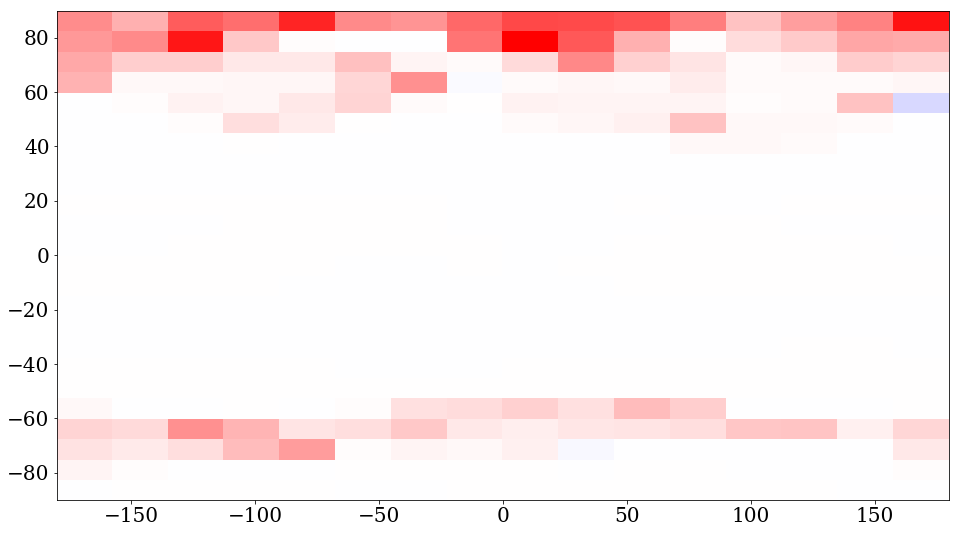

In [7]:
y=2100

fig= plt.figure(figsize=(16,9))
ax=fig.add_subplot(111)
diff=p[np.where(years==y)[0][0]].data_vars['as'].mean(dim="Time")-ref[np.where(years==y)[0][0]].data_vars['as'].mean(dim="Time")
#plot=ax.pcolormesh(X_atl,Y_atl,change_to_Atl(diff), cmap='Greys_r', alpha=1)
vmax=0.02


plot=ax.pcolormesh(X_atl,Y_atl,change_to_Atl(diff), cmap='bwr_r', alpha=1, vmin=-vmax, vmax=vmax)
m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
m.drawcoastlines()

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
cb=plt.colorbar(plot, cax=cax, label=r'$\Delta \alpha_S$')
#cb.ax.set_yticklabels(['%.3f' % float(tick) for tick in cb.ax.get_yticklabels()[:]])

ax.set_title("Change of Albedo in "+str(y)+r" ($\overline{P_{\rm hum}\cdot {\rm Fr}_{\rm land}}="+
             '%.3f' % area_mean_lon(data_grid.frlnd[0] * P[np.where(years==y)[0][0]])+r"\, {\rm W/m^2}$)"+r"$\rightarrow$"
            +r"$\overline{\Delta \alpha_S}=$"+ '%.5f' % area_mean_lon(diff))

ax.set_xticks([X_atl[0,:][0],X_atl[0,:][len(X_atl[0,:])/4],\
           X_atl[0,:][len(X_atl[0,:])/2],X_atl[0,:][len(X_atl[0,:])/4*3], X_atl[0,:][-1]])
ax.set_yticks([Y_atl[:,0][0],Y_atl[:,0][len(Y_atl[:,0])/4],\
           Y_atl[:,0][len(Y_atl[:,0])/2],Y_atl[:,0][len(Y_atl[:,0])/4*3], Y_atl[:,0][-1]])
ax.set_xlabel("  ")
ax.tick_params(axis='both', which='major', labelsize=16)


grid=ref[-1]
crosses_x=[]
crosses_y=[]
for i in range(0,16):
    for j in range(0,24):
        a=grid.xt_i[i].values-180
        crosses_x.append(a)
        crosses_y.append(grid.yt_j[j].values)
ax.plot(crosses_x[:], crosses_y[:], '.', ms=1, color='black', alpha=0.7)

fig.tight_layout()
plot_name= "Map_deltaAlbedo_"+runname+"_"+str(y)
plt.savefig(plot_name+".eps" ,bbox_inches='tight', format='eps')

# Plot Delta alpha over theta

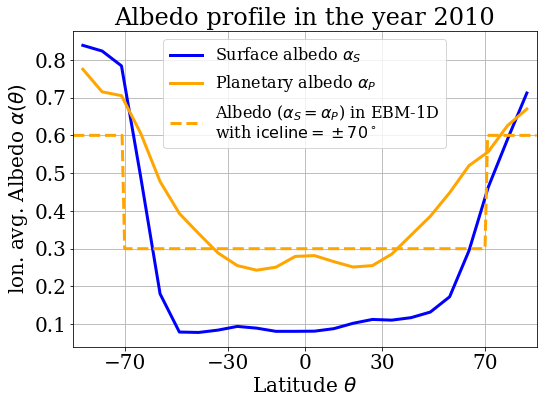

In [11]:
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
y=2010
ind=np.where(years==y)[0][0]
ax.plot(ref[ind].yt_j, ref[ind].data_vars['as'].mean(dim="Time").mean(dim='xt_i'), 
        label=r'Surface albedo $\alpha_S$', lw=3, color='blue')
ax.plot(ref[ind].yt_j, ref[ind].data_vars['ap'].mean(dim="Time").mean(dim='xt_i'), 
        label=r'Planetary albedo $\alpha_P$', lw=3, color='orange')
lats_EBM=np.arange(-90,91, step=1)
albedo=[]
for l in lats_EBM:
    if abs(l)>70: 
        albedo.append(0.6)
    else: 
        albedo.append(0.3)

ax.plot(lats_EBM, albedo, '--', label=r'Albedo ($\alpha_S=\alpha_P$) in EBM-1D '+'\n'+r'with ${\rm iceline}=\pm70^\circ$', lw=3, color='orange')
ax.set_yticks([0.1+k*0.1 for k in range(0,8)])
ax.set_xticks([-70, -30, 0,30,70])
ax.set_xlim(-90,90)
ax.set_xlabel(r'Latitude $\theta$')
ax.set_ylabel(r'lon. avg. Albedo $\alpha(\theta)$')
ax.grid(which='major')
ax.set_title('Albedo profile in the year 2010')
ax.legend(fontsize=16)
fig.tight_layout()
plt.savefig('albedo_profile.eps', format='eps', bbox_inches='tight')

# Plot Delta ASlpha over time

In [8]:
diffs_as=[]
diffs_ap=[]
for y in years:
    i=np.where(years==y)[0][0]
    diffs_as_2D=p[i].data_vars['as'].mean(dim="Time")-ref[i].data_vars['as'].mean(dim="Time")
    diffs_ap_2D=p[i].data_vars['ap'].mean(dim="Time")-ref[i].data_vars['ap'].mean(dim="Time")
    diffs_as.append(area_mean_lon(diffs_as_2D))
    diffs_ap.append(area_mean_lon(diffs_ap_2D))


(<xarray.DataArray 'as' ()>
array(-0.000807), <xarray.DataArray 'ap' ()>
array(-0.000539))


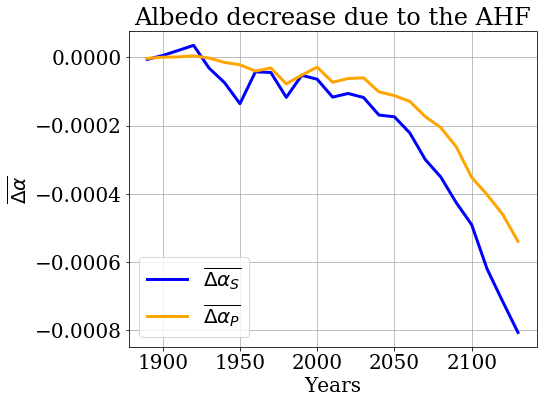

In [13]:
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.plot(years, diffs_as, '-', lw=3, color='blue', label=r'$\overline{\Delta \alpha_S}$')
ax.plot(years, diffs_ap, '-', lw=3, color='orange', label=r'$\overline{\Delta \alpha_P}$')
ax.set_xlabel(r"Years")
ax.set_ylabel(r"$\overline{\Delta \alpha}$")
ax.set_title('Albedo decrease due to the AHF')

#yticks=[]
#for tick in ax.get_yticks():
#        yticks.append('%.e' % tick)
#ax.set_yticklabels(yticks)
ax.grid()
ax.legend()
fig.tight_layout()
print(min(diffs_as), min(diffs_ap))
plt.savefig("albedo_change_over_timeUntil2130.eps", format='eps', bbox_inches='tight')

In [22]:
diffs_ap[np.where(years==2100)[0][0]]

<xarray.DataArray 'ap' ()>
array(-0.0005392920345287852)

In [32]:
diffs_as[np.where(years==2100)[0][0]]/area_mean_lon(ref[np.where(years==2100)[0][0]].data_vars['as'].mean(dim="Time"))

<xarray.DataArray 'as' ()>
array(-0.003094688837735281)

In [19]:
Nlats=360
lats_star=np.linspace(-90, 90, num=Nlats+1)
lats=(lats_star[:-1]+ lats_star[1:])/2

da=(0.3-0.6) * np.cos(65.5*np.pi/180) / np.sum(np.cos(lats*np.pi/180))
da

-0.0005428304628010889

## Look at the highest cell. What percentage albedo change is that? Spitzbergen

In [50]:
i=np.where(years==2100)[0][0]
diffs_as_2D=p[i].data_vars['as'].mean(dim="Time")-ref[i].data_vars['as'].mean(dim="Time")

In [55]:
np.min(diffs_as_2D)

<xarray.DataArray 'as' ()>
array(-0.019930964956680952)

In [56]:
np.where(diffs_as_2D==np.min(diffs_as_2D))

(array([22]), array([0]))

In [57]:
ref2100=ref[np.where(years==2100)[0][0]].data_vars['as'].mean(dim="Time")
ref2100[22,0]

<xarray.DataArray 'as' ()>
array(0.20739947197337946)
Coordinates:
    xt_i     float32 11.25
    yt_j     float32 78.75

In [58]:
diffs_as_2D[22,0]/ref2100[22,0]

<xarray.DataArray 'as' ()>
array(-0.0960994006736872)
Coordinates:
    xt_i     float32 11.25
    yt_j     float32 78.75

### That means roughlt 10Percent loss of albedo in spitzbergen